In [1]:
import pandas as pd
import pyslammer as slam
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import ConnectionPatch
import numpy as np
import scipy.stats.mstats as ssmstat

from verification_processes import import_verification_data

%matplotlib widget

df = import_verification_data("SLAMMER_results.xlsx")
df["kykmax"] = df["ky (g)"] / df["kmax (g)"]

In [2]:

gui_time = 18*6*12 
slammer_runtime = 70/2 * 12
total_runtime = (gui_time + slammer_runtime)/60
pyslammer_runtime = (3*60 + 27)/60
total_runtime/pyslammer_runtime
gui_time/slammer_runtime

3.085714285714286

Note: 
It took 30.7 seconds to run 522 pyslammer simulations (three each).
It took about 12 seconds to run 18 SLAMMER simulations (six each). The actual runtime for the simulations ranged from 0.7 to 71 seconds depending on whether linear elastic or equivalent linear soil model was used.

now running 1260 simulations in pyslammer. 1 min, 37 seconds. Actually, that was mistakenly only running the simulations as linear elastic. the 234 equivalent linear simulations were getting run with only the linear elastic model. when this is corrected, running all the simulations takes 2 min, 17 seconds. That was when I was just running the normal direction. I added the inverse and re-ran (3 minutes 27 seconds).

I had another case where the points weren't in good agreement and after digging into it it was a typo again in how I recoreded my SLAMMER results. Every manual entry is an opportunity for error. This is another motivation behind pySLAMMER. With more programmatic inputs and an output that records the actual input values used in the simulation, this kind of error is les likely to occur.

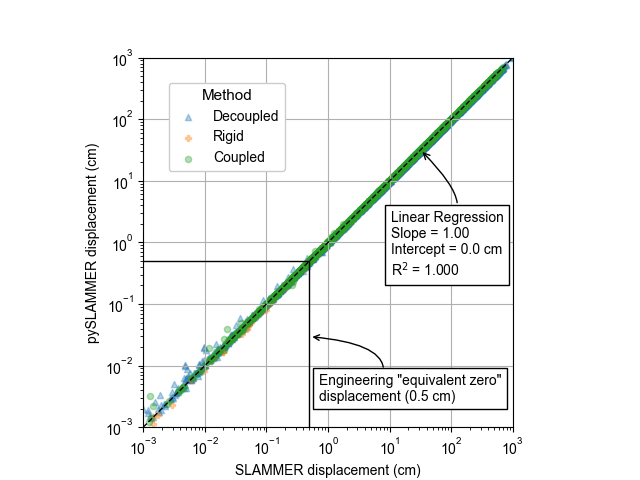

In [3]:
dfp = df[df["kykmax"] < 1.0]

slope, intercept, r, p, se = ssmstat.linregress(
    dfp["SLAMMER"],
    dfp["pySLAMMER"],
)


plt.close("all")
############
# pySLAMMER v. SLAMMER
############
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["savefig.dpi"] = 600

fig, ax = plt.subplots()
# cmap = plt.cm.viridis



# # Match color values to kykmax values
# color_values = dfp["kykmax"]

# # Scatter plot with color mapping
# scatter = ax.scatter(
#     dfp["SLAMMER"],  # x-axis values
#     dfp["pySLAMMER"],  # y-axis values
#     c=color_values,  # Numeric values for coloring
#     cmap=cmap,  # Colormap
#     alpha=0.8,  # Transparency
#     marker=".",
# )

# # Add colorbar
# cbar = plt.colorbar(scatter, ax=ax, alpha=1)
# cbar.set_label("Yield Ratio ($k_y/k_{max}$)")  # Label for the colorbar

keys = ["Decoupled", "Rigid", "Coupled"]
markers = ["^", "P", "o"]
# markers = [".", ".", "."]

for i, key in enumerate(keys):
    grp = dfp[dfp["Method"] == key]
    ax.scatter(grp["SLAMMER"], 
               grp["pySLAMMER"], 
               label=key, 
               alpha=0.35,
               marker=markers[i],
               s=20
               )
# for key, grp in df.groupby(["Method"]):
#     ax.scatter(grp["SLAMMER"], 
#                grp["pySLAMMER"], 
#                label=key[0], 
#                alpha=0.5,
#                marker=".",
#                )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-3, 1e3)
ax.set_ylim(1e-3, 1e3)

ax.set_aspect("equal")

plt.grid()

ax.set_xlabel("SLAMMER displacement (cm)")
ax.set_ylabel("pySLAMMER displacement (cm)")

# Linear regression

ax.plot([1e-3, 1e3], [1e-3, 1e3], color="black", linestyle="--", linewidth=1)

ax.text(
    0.67,
    0.585,
    f"Linear Regression\nSlope = {slope:.2f}\nIntercept = {intercept:.1f} cm\nR$^2$ = {r**2:.3f}",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=1),
)

# Arrow for linear regression
arrow = FancyArrowPatch(
    (0.85, 0.6),  # Start point (near text box)
    (0.75, 0.75),  # End point (middle of plot, on dashed line)
    connectionstyle="angle3,angleA=90,angleB=-45",  # Angle connection style
    transform=ax.transAxes,
    arrowstyle="->",
    mutation_scale=11,
    color="black",
    alpha=1,
    zorder=4
)
ax.add_patch(arrow)

# Engineering range of interest
ax.plot([0,0.5,0.5],[0.5,0.5,0], color="black", linestyle="-", linewidth=1)

# Add text box with regression statistics
ax.text(
    0.475,
    0.145,
    "Engineering \"equivalent zero\"\ndisplacement (0.5 cm)",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=1),
)

# Arrow for linear regression
arrow = FancyArrowPatch(
    (0.65, 0.155),  # Start point (near text box)
    (0.45, 0.245),  # End point (middle of plot, on dashed line)
    connectionstyle="angle3,angleA=90,angleB=-5",  # Angle connection style
    transform=ax.transAxes,
    arrowstyle="->",
    mutation_scale=10,
    color="black",
    alpha=1,
    zorder=4,
)
ax.add_patch(arrow)

# Add legend
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.05, 0.95),
    fontsize=10,
    title="Method",
    title_fontsize="11",
    framealpha=1,
)

plt.show()

In [4]:
plt.savefig("SLAMMER_comp.pdf", dpi=600, bbox_inches="tight")

In [5]:
scales = [0.001, 0.01, 0.1, 1, 10, 100]
for scale in scales:
    segment = dfp[
        (dfp["SLAMMER"] > scale)
        & (dfp["SLAMMER"] < scale * 10)

    ]
    slope, intercept, r, p, se = ssmstat.linregress(
        segment["SLAMMER"],
        segment["pySLAMMER"],
    )

    max_diff = max(
        abs(segment["pySLAMMER"] - segment["SLAMMER"])
    )
    mean_diff = np.mean(
        abs(segment["pySLAMMER"] - segment["SLAMMER"])
    )
    std_diff = np.std(
        abs(segment["pySLAMMER"] - segment["SLAMMER"])
    )
    p_95 = np.percentile(
        abs(segment["pySLAMMER"] - segment["SLAMMER"]),
        95,
    )
    print(
        f"""Scale: {scale} to {10 * scale} cm:
            Slope = {slope:.2f}, Intercept = {intercept:.2f}, 
            R^2 = {r**2:.3f}, P-value = {p:.3f}, SE = {se:.3f}
            Max difference = {max_diff:.2f} cm, 95th percentile error {p_95:.2f} cm"""
    )


Scale: 0.001 to 0.01 cm:
            Slope = 1.06, Intercept = 0.00, 
            R^2 = 0.538, P-value = 0.000, SE = 0.098
            Max difference = 0.02 cm, 95th percentile error 0.01 cm
Scale: 0.01 to 0.1 cm:
            Slope = 1.00, Intercept = 0.00, 
            R^2 = 0.986, P-value = 0.000, SE = 0.006
            Max difference = 0.03 cm, 95th percentile error 0.01 cm
Scale: 0.1 to 1.0 cm:
            Slope = 1.00, Intercept = 0.00, 
            R^2 = 0.998, P-value = 0.000, SE = 0.002
            Max difference = 0.10 cm, 95th percentile error 0.02 cm
Scale: 1 to 10 cm:
            Slope = 1.00, Intercept = 0.00, 
            R^2 = 1.000, P-value = 0.000, SE = 0.000
            Max difference = 0.44 cm, 95th percentile error 0.07 cm
Scale: 10 to 100 cm:
            Slope = 1.00, Intercept = 0.00, 
            R^2 = 1.000, P-value = 0.000, SE = 0.000
            Max difference = 0.97 cm, 95th percentile error 0.27 cm
Scale: 100 to 1000 cm:
            Slope = 1.00, Intercept =

In [39]:
# compare with pyNewmarkDisp
from pynewmarkdisp import newmark as pnd

df_rigid = df[(df["Method"] == "Rigid") & (df["Direction"] != "Average")]

# Add an empty column for the pyNewmarkDisp displacements
df_rigid["pyNewmarkDisp"] = np.nan
motions = slam.sample_ground_motions()
# Loop through each row in df_rigid
for index, row in df_rigid.iterrows():
    # find the pyslammer sample ground motion that matches the earthquake name and record
    # The motion keys are strings of the form "Earthquake_Record"
    # e.g. "Northridge_1994_01_17_000"
    # all the spaces should be replaced with underscores
    motion_key = f"{row['Earthquake'].replace(' ', '_').replace(',', '').replace('.', '')}_{row['Record']}"
    if row['Direction'] == 'Inverse':
        sign = -1
    else:
        sign = 1
    gm = motions.get(motion_key, None)
    if gm is not None:
        # create a time array based on the ground motion's acceleration and dt
        time = np.arange(0, len(gm.accel)*gm.dt, step=gm.dt)
        acc = sign * row['Scale']*gm.accel/max(abs(gm.accel))  # scale the acceleration by the record's scale factor

        # find the displacement with pyNewmarkDisp
        disp = pnd.direct_newmark(time, acc, row['ky (g)'], g=1)

        # add the pyNewmarkDisp displacement to the dataframe
        df_rigid.loc[index, "pyNewmarkDisp"] = disp["perm_disp"]*100

    # create a time array based on the ground motion's acceleration and dt

    # find the displacement with pyNewmarkDisp

    # add the pyNewmarkDisp displacement to the dataframe

# time = np.arange(0, len(gm.accel)*gm.dt)

/var/folders/q0/kxmqm5c95n7cxc6mmqklw1k40000gq/T/ipykernel_37731/1485914473.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rigid["pyNewmarkDisp"] = np.nan


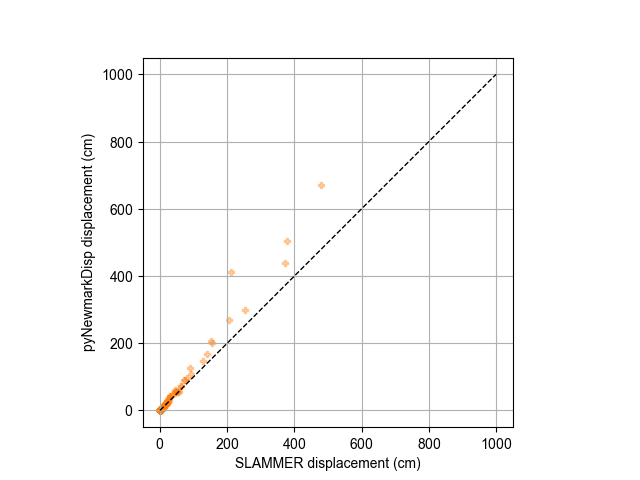

In [40]:
dfp = df_rigid[df_rigid["kykmax"] < 1.0]

plt.close("all")
############
# pySLAMMER v. SLAMMER
############
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["savefig.dpi"] = 600

fig, ax = plt.subplots()
# cmap = plt.cm.viridis


# # Match color values to kykmax values
# color_values = dfp["kykmax"]

# # Scatter plot with color mapping
# scatter = ax.scatter(
#     dfp["SLAMMER"],  # x-axis values
#     dfp["pySLAMMER"],  # y-axis values
#     c=color_values,  # Numeric values for coloring
#     cmap=cmap,  # Colormap
#     alpha=0.8,  # Transparency
#     marker=".",
# )

# # Add colorbar
# cbar = plt.colorbar(scatter, ax=ax, alpha=1)
# cbar.set_label("Yield Ratio ($k_y/k_{max}$)")  # Label for the colorbar

keys = ["Decoupled", "Rigid", "Coupled"]
markers = ["^", "P", "o"]
# markers = [".", ".", "."]

for i, key in enumerate(keys):
    grp = dfp[dfp["Method"] == key]
    ax.scatter(
        grp["SLAMMER"],
        grp["pyNewmarkDisp"],
        label=key,
        alpha=0.35,
        marker=markers[i],
        s=20,
    )
# for key, grp in df.groupby(["Method"]):
#     ax.scatter(grp["SLAMMER"],
#                grp["pySLAMMER"],
#                label=key[0],
#                alpha=0.5,
#                marker=".",
#                )

# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.set_xlim(1e-3, 1e3)
# ax.set_ylim(1e-3, 1e3)

ax.set_aspect("equal")

plt.grid()

ax.set_xlabel("SLAMMER displacement (cm)")
ax.set_ylabel("pyNewmarkDisp displacement (cm)")

# Linear regression

ax.plot([1e-3, 1e3], [1e-3, 1e3], color="black", linestyle="--", linewidth=1)

# Engineering range of interest
ax.plot([0, 0.5, 0.5], [0.5, 0.5, 0], color="black", linestyle="-", linewidth=1)

# Add legend
# ax.legend(
#     loc="upper left",
#     bbox_to_anchor=(0.05, 0.95),
#     fontsize=10,
#     title="Method",
#     title_fontsize="11",
#     framealpha=1,
# )

plt.show()


In [ ]:
slope, intercept, r, p, se = ssmstat.linregress(
        dfp["SLAMMER"],
        dfp["pySLAMMER"],)

print(
    f"""Slope = {slope:.2f}, Intercept = {intercept:.2f}, 
        R^2 = {r**2:.3f}, P-value = {p:.3f}, SE = {se:.3f}"""
)

Slope = 1.00, Intercept = 0.01, 
        R^2 = 1.000, P-value = 0.000, SE = 0.000


In [42]:
slope

np.float64(1.3367275895321349)